# 1. Подготовка

In [1]:
from transformers import BertTokenizer, BertModel
import pandas as pd
import numpy as np
import torch
import time
import os

from pymystem3 import Mystem
from tqdm import notebook
import re
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

SEED = 777

In [2]:
# Откроем и взглянем на датасет
df = pd.read_csv('/datasets/toxic_comments.csv')
print(df.info())
print('\nДоля токсичных сообщений {:2.2%}'.format(df['toxic'].sum() / df['toxic'].count()))
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB
None

Доля токсичных сообщений 10.17%


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


С помощью регулярных выражений почистим датасет. Удалим html теги, http ссылки, вычистим лишние символы.

In [3]:
# Удалим html теги
df['text_reg'] = df['text'].apply(
    lambda x: " ".join(re.sub(r'<[^>]+>', ' ', x).split()))
print('html теги удалены')

# Удалим http ссылки
df['text_reg'] = df['text'].apply(
    lambda x: " ".join(re.sub(r'(?i)\b((?:http?://|www\d{0,3}[.])(.)+\s)', ' ', x).split()))
print('http ссылки удалены')

# Оставим только буквы
df['text_reg'] = df['text_reg'].apply(
    lambda x: " ".join(re.sub(r'[^a-zA-Z\',.!?]', ' ', x).split()))
print('Удалены лишние символы')

# Сгруппируем повторяющиеся символы всречающиеся более двух раз
df['text_reg'] = df['text_reg'].apply(
    lambda x: " ".join(re.compile(r'(.)\1{2,}').sub(r'\1', x).split()))
print('Сгруппированы символы встречающиеся более двух раз')

# Удалим отдельно стоящие символы встречающиеся один или два раза сподряд(кроме артикля 'a' и местоимения 'I')
df['text_reg'] = df['text_reg'].apply(
    lambda x: " ".join(re.sub(r'\b([^aAiI])\1{,2}\b', ' ', x).split()))
print("Удалены отдельно стоящие символы встречающиеся один или два раза сподряд(кроме 'a' и 'I')")

# Удалим отдельно стоящие символы 'aa', 'AA', 'ii', 'II'
df['text_reg'] = df['text_reg'].apply(
    lambda x: " ".join(re.sub(r'\b([aAiI])\1+\b', ' ', x).split()))
print("Удалены отдельно стоящие символы 'aa', 'AA', 'ii', 'II'")

html теги удалены
http ссылки удалены
Удалены лишние символы
Сгруппированы символы встречающиеся более двух раз
Удалены отдельно стоящие символы встречающиеся один или два раза сподряд(кроме 'a' и 'I')
Удалены отдельно стоящие символы 'aa', 'AA', 'ii', 'II'


In [4]:
# Лематизируем сообщения
lemmatizer = WordNetLemmatizer()

df['text_reg_lem'] = df['text_reg'].apply(
    lambda x: lemmatizer.lemmatize(x))

In [6]:
# Посчитаем кол-во слов в сообщениях
df['length'] = df['text_reg_lem'].apply(lambda x: len(x.split()))
print('Слова в каждом сообщении посчитаны')

# найдем среднюю длинну слова в сообщениях(кол-во букв делим на кол-во слов)
df['length_word_avg'] = df['text_reg_lem'].apply(
    lambda x: len(''.join(x.split()))) / df['length']
print('Средняя длинна слова в каждом сообщении найдена')

Слова в каждом сообщении посчитаны
Средняя длинна слова в каждом сообщении найдена


In [7]:
# Проверим наличие сообщений с нулевой длинной
df.loc[df['length']==0].head()
# Удалим их
df = df.loc[df['length']>0]

In [8]:
# После удаления сообщений нулевой длинны можно добавить еще один признак
# отношение длинны исходного текста к очищенному тексту
df['rang_sent'] = df.apply(lambda x: len(x['text']) / len(x['text_reg_lem']), axis=1)

Далее создадим функцию отображения боксплотов и удаления аномалий в новых признаках ***length***, ***length_word_avg*** и ***rang_sent***

In [9]:
# Функция отображения боксплотов
def show_boxplot(data, column='all'):
    np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 

    if column in ['length_word_avg','all']:
        ax = data[['toxic', 'length_word_avg']].boxplot(vert=False, by='toxic', figsize=(12, 2))
        ax.set_xlabel('Средняя длинна слова в сообщении length_word_avg')
        ax.set_title('')
    if column in ['rang_sent','all']:
        ax = data[['toxic', 'rang_sent']].boxplot(vert=False, by='toxic', figsize=(12, 2))
        ax.set_xlabel('Отношение исходного сообщения к очищенному rang_sent')
        ax.set_title('')
    if column in ['length','all']:
        ax = data[['toxic', 'length']].boxplot(vert=False, by='toxic', figsize=(12, 2))
        ax.set_xlabel('Длинна сообщения length')
        ax.set_title('')

In [10]:
# Функция удаления аномалий
def del_anomaly(data, column, percent=0.75, clear_left_side=False):
    perc_lift  = data[column].quantile(1-percent)
    perc_right = data[column].quantile(percent)

    if percent == 0.75:
        iqr = (perc_right - perc_lift)*1.5
    else:
        iqr = 0

    ind  =  (data[column] < perc_right+iqr)
    if clear_left_side:
        ind  = (ind & (data[column] > perc_lift-iqr))

    return data.loc[ind], data.loc[~ind]

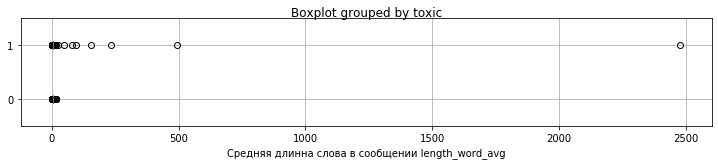

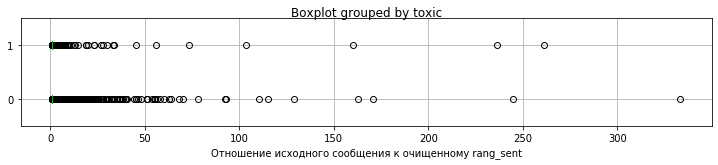

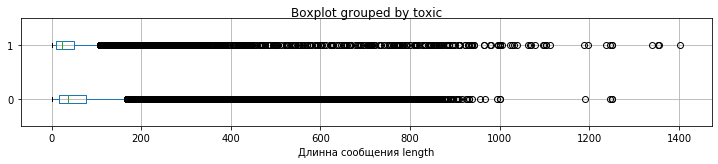

In [11]:
# Взглянем на length_word_avg, rang_sent, length
show_boxplot(df)

Видим что все распределения имеют большие выбросы. Воспользуемся функцией del_anomaly для их удаления.

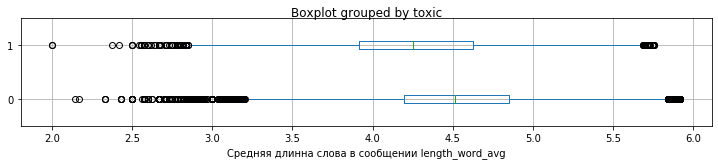

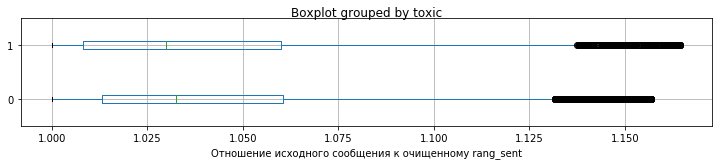

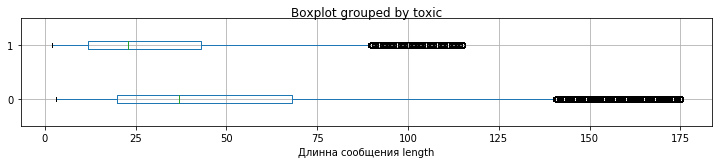

In [12]:
# Удалим сообщения с аномально длинными словами в сообщении
df_clean = pd.concat([del_anomaly(df.loc[df['toxic']==1], 'length_word_avg')[0],
                      del_anomaly(df.loc[df['toxic']==0], 'length_word_avg')[0]])
# Удалим сообщения с высоким значением rang_sent (отношение длинны исходных сообщений к очищенным)
df_clean = pd.concat([del_anomaly(df_clean.loc[df_clean['toxic']==1], 'rang_sent')[0],
                      del_anomaly(df_clean.loc[df_clean['toxic']==0], 'rang_sent')[0]])
# Удалим очень длинные сообщения
df_clean = pd.concat([del_anomaly(df_clean.loc[df_clean['toxic']==1], 'length')[0],
                      del_anomaly(df_clean.loc[df_clean['toxic']==0], 'length')[0]])
# Посмотрим что получилось
show_boxplot(df_clean)

После удаления явно мусорных сообщений распределения выглядят намного лучше. Видим что среднее количество букв в словах примерно равно 4-5, средняя длинна сообщений примерно 25-30 слов, и что исходное сообщение в среднем на 3% состоит из смайликов и прочих знаков не входящих в алфавит.

# 2. Обучение

### TF-IDF

Вычислим TF-IDF для корпуса текстов. Для этого воспользуемся классом TfidfVectorizer(). Перед тем как считать TF-IDF загрузим стоп слова и подготовим словарь ***vocab***, для того что бы ускорить процесс создания векторов.

In [13]:
# запустим таймер
start = time.time()

In [14]:
# Загрузим стоп слова
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
# преобразуем корпус текстов в мешок слов, обратимся к классу CountVectorizer()
# Создадим счётчик
count_vect = CountVectorizer(stop_words=stopwords)
# Создадим корпус из всех сообщений
corpus = list(df_clean['text_reg_lem'])
# посчитаем количество слов в каждом сообщении
n_gramm_toxic  = count_vect.fit_transform(corpus)
n_gramm_toxic.shape

(128090, 116941)

In [16]:
# посчитаем количество слов в корпусе, проссумируем все n-граммы
vocab = np.zeros((1,n_gramm_toxic.shape[1]))
for i in range(0, n_gramm_toxic.shape[0]):
    vocab += n_gramm_toxic[i].toarray()[0]

In [17]:
# Выделим слова которые втречаются более двух раз во всем корпусе
vocab = pd.Series(count_vect.get_feature_names())[(vocab[0]>2)]
print('Кол-во слов в словаре vocab:',len(vocab))

Кол-во слов в словаре vocab: 41210


In [18]:
# Разобьем датафрейм на тренировочные и тестовые данные
X_train, X_test, y_train, y_test = train_test_split(
    df_clean['text_reg_lem'], df_clean['toxic'], test_size=0.3, random_state=SEED)

In [19]:
# Вычислим TF-IDF для тренировочных и тестовых данных
count_tf_idf = TfidfVectorizer(vocabulary=vocab,
                               stop_words=stopwords)
tf_idf_train = count_tf_idf.fit_transform(X_train)
tf_idf_test  = count_tf_idf.transform(X_test)

print('Размер tf_idf_train:',tf_idf_train.shape)
print('Размер tf_idf_test:',tf_idf_test.shape)

Размер tf_idf_train: (89663, 41210)
Размер tf_idf_test: (38427, 41210)


In [20]:
# Создадим и обучим логистическую регрессию. Предскажем токсичность сообщения
model_log = LogisticRegression(max_iter=1000000, class_weight='balanced', solver='lbfgs')
model_log.fit(tf_idf_train, y_train)
predicted = model_log.predict(tf_idf_test)

In [21]:
# Посмотрим на метрику
display(confusion_matrix(y_test, predicted))
display(        f1_score(y_test, predicted))

array([[32971,  1545],
       [  587,  3324]])

0.7571753986332572

In [22]:
# Вычислим итоговой время
end = time.time()
total_time = end - start

In [23]:
# Создадим фрейм куда будем записывать итоговые результаты
result = pd.DataFrame(columns=['F1', 'Время', 'Кол-во сообщений', 'сообщений в секунду'],
                      index=['TF-IDF', 'BERT', 'better-profanity'])

In [24]:
# Запишем результаты
result.loc['TF-IDF'] = [f1_score(y_test, predicted),total_time,len(df_clean),len(df_clean)/total_time]

### BERT

Классифицируем сообщения с помощью предобученой нейронной сети BERT

In [25]:
# запустим таймер
start = time.time()

In [26]:
# инициализируем предобученную модель 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model     = BertModel.from_pretrained("bert-base-cased")

In [27]:
# Т.к. Bert работает не прилично долго, обрежем наш датафрейм.
# Ограничимся кол-вом сообщений 1200 и кол-вом слов в сообщении 20
MAX_LEN = 20
SAMP    = 1200

In [28]:
# Создадим укороченный фрейм для более быстрой токенизации сообщений.
# Возьмем сообщения обработанные только регулярками(не лемматизированные)
df_samp = df_clean.loc[df_clean['length']<MAX_LEN][['text_reg','toxic']]
df_samp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34147 entries, 6 to 159556
Data columns (total 2 columns):
text_reg    34147 non-null object
toxic       34147 non-null int64
dtypes: int64(1), object(1)
memory usage: 800.3+ KB


In [29]:
# Токенизируем сообщения
df_samp['tokenized'] = df_samp['text_reg'].apply(
    lambda x: tokenizer.encode(text=x, add_special_tokens=True))

In [30]:
# Посчитаем длинну токенов
df_samp['length_token'] = df_samp['tokenized'].apply(lambda x: len(x))
print('Максимальная длинна length_token:', df_samp['length_token'].max())

Максимальная длинна length_token: 68


In [31]:
# Создадим семпл из 1200 записей с количеством токенов не более 20 в сообщении
df_samp = df_samp.loc[df_samp['length_token']<=MAX_LEN].sample(SAMP, random_state=SEED).reset_index(drop=True)
df_samp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 4 columns):
text_reg        1200 non-null object
toxic           1200 non-null int64
tokenized       1200 non-null object
length_token    1200 non-null int64
dtypes: int64(2), object(2)
memory usage: 37.6+ KB


In [32]:
# Применим метод padding, чтобы после токенизации длины исходных текстов в корпусе были равными
padded = np.array([i + [0]*(MAX_LEN - len(i)) for i in df_samp['tokenized']])
padded

array([[  101,  1135,  1336, ...,     0,     0,     0],
       [  101,  1714,  4055, ...,     0,     0,     0],
       [  101,  1135,  1156, ..., 11116,   102,     0],
       ...,
       [  101, 12105,  2266, ...,     0,     0,     0],
       [  101,  2814,  1133, ...,     0,     0,     0],
       [  101, 17035,   117, ...,   119,   102,     0]])

In [33]:
# создадим маску для действительно важных токенов, то есть укажем нулевые и не нулевые значения
attention_mask = np.where(padded != 0, 1, 0)
attention_mask

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 0]])

In [34]:
# преобразуем текст в эмбеддинги
batch_size = 100
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    # сформируем название файла
    FILE = 'text_project/'+str(i)+'_batch_embeddings_'+str(MAX_LEN)+'_'+str(SAMP)
    # проверим его наличие на диске
    if os.path.exists(FILE):
        print(f'batch номер {i} существует')
    else:
        # Преобразуем батчи в формат тензоров
        batch                = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])

        with torch.no_grad():
            # получим эмбеддинги для батча
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        # Из полученного тензора извлечём нужные элементы и положим в датафрейм
        batch_embeddings = pd.DataFrame(batch_embeddings[0][:,0,:].numpy(),
                                        index=range(batch_size*i,batch_size*(i+1)))
        # Сохраним полученные результаты на диск
        batch_embeddings.to_csv(FILE)

batch номер 0 существует
batch номер 1 существует
batch номер 2 существует
batch номер 3 существует
batch номер 4 существует
batch номер 5 существует
batch номер 6 существует
batch номер 7 существует
batch номер 8 существует
batch номер 9 существует
batch номер 10 существует
batch номер 11 существует



In [35]:
# Сформируем фичи из данных сохраненных на диске
features = pd.DataFrame()
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    FILE = 'text_project/'+str(i)+'_batch_embeddings_'+str(MAX_LEN)+'_'+str(SAMP)
    try:
        batch_embeddings = pd.read_csv(FILE,index_col=0)
        features = pd.concat([features,batch_embeddings])
    except:
        print(f'batch номер {i} прочитать не удалось')

In [36]:
# Посмотрим на фичи
features.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.224470,-0.078813,-0.237825,-0.210910,-0.117921,-0.109113,0.117948,-0.324353,0.249993,-1.354110,...,0.134500,0.033655,-0.226989,-0.167254,0.077891,0.471322,-0.190089,-0.085309,0.263145,0.245470
1,0.502043,0.224226,0.062600,-0.345038,-0.196127,0.031848,0.382606,-0.119130,-0.044952,-1.108494,...,0.198867,0.023494,-0.074363,-0.432457,-0.075769,0.191576,-0.123027,0.033523,0.367351,0.123113
2,0.541353,0.230933,0.059292,-0.019696,-0.118712,0.128101,0.163292,0.009640,0.022919,-1.084911,...,0.069696,0.103773,-0.165122,-0.157391,0.351432,0.032904,0.183194,-0.445148,0.221384,-0.176315
3,0.555767,0.263704,0.285267,-0.111135,0.007964,-0.004756,0.134957,-0.140002,-0.144645,-1.081590,...,0.101441,0.199684,-0.029401,-0.160185,0.102718,0.011862,0.157427,-0.202056,0.338408,0.118458
4,0.368619,0.320599,-0.045075,-0.254166,-0.182888,-0.066047,0.475035,-0.125288,-0.010496,-1.095179,...,0.226233,0.176163,-0.213128,-0.101869,-0.030485,0.172609,0.101096,-0.173483,0.370377,0.245178


In [37]:
# разобьем фичи и целевой признак на тренировочные и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(
    features, df_samp['toxic'], test_size=0.3, random_state=SEED)

In [38]:
# Создадим и обучим логистическую регрессию, предскажем токсичность
model_lr = LogisticRegression(max_iter=1000000, class_weight='balanced', solver='lbfgs')
model_lr.fit(X_train, y_train)
predicted = model_lr.predict(X_test)

In [39]:
# Посмотрим на метрики
display(confusion_matrix(y_test, predicted))
f1_score(y_test, predicted)

array([[278,  16],
       [ 11,  55]])

0.8029197080291971

In [40]:
# Вычислим итоговой время
end = time.time()
total_time = end - start

In [41]:
# Запишем результаты
result.loc['BERT'] = [f1_score(y_test, predicted),total_time,SAMP,SAMP/total_time]

### better-profanity

На просторах интернета найдена библиотека better-profanity. Попробуем предсказать токсичность сообщений с помощью нее

In [42]:
# запустим таймер
start = time.time()

In [43]:
# Установим и импортируем библиотеку
!pip install better_profanity
from better_profanity import profanity

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 46 kB 895 kB/s eta 0:00:011


In [44]:
# предскажем токсичность
df_samp['profanity'] = df_samp['text_reg'].apply(lambda x: 1 if profanity.contains_profanity(x) else 0)

In [45]:
# посмотрим на метрику
display(confusion_matrix(df_samp['profanity'], df_samp['toxic']))
display(        f1_score(df_samp['profanity'], df_samp['toxic']))

array([[985,  54],
       [ 17, 144]])

0.8022284122562674

In [46]:
# Вычислим итоговой время
end = time.time()
total_time = end - start

In [47]:
# Запишем результаты
result.loc['better-profanity'] = [f1_score(df_samp['profanity'], df_samp['toxic']),total_time,SAMP,SAMP/total_time]

# 3. Выводы

В данном проекте были классифицированы комментарии на позитивные и негативные. Для этого были обучены модели логистической регрессии на основе TF-IDF и на основе эмбеддингов полученных с помощью неро сети BERT. Так же была применена библиотека **better-profanity**.

In [48]:
result

,F1,Время,Кол-во сообщений,сообщений в секунду
TF-IDF,0.757175,72.0525,128090,1777.73
BERT,0.80292,265.619,1200,4.51775
better-profanity,0.802228,55.119,1200,21.7711


Как видим все модели уложились в метрику качества F1 не меньше 0.75. Однако стоит заметить что модель на основе **TF-IDF** обучалась и предсказывала токсичные сообщения на всем датафрейме, а модель на основе **BERT** и библиотека **better-profanity** на датафрейме из 1200 сообщений с длинной не более 20 слов. Таким образом можно зделать вывод что **TF-IDF** более предпочтительна если есть ограничения в ресурсках и необходима скорость. **BERT** показывает не плохие результаты но работает значительно медленней и требует правильной настройки.

PS *Время* и *сообщений в секунду* в данном случае весьма условно т.к. включает в себя не только время обучения модели и предсказания, но и время предобрабтки сообщений(токенизация и пр.).

# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны